# Journal Profiling Part 1: Getting the Data

This Python notebook shows how to use the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) to extract [publications data ](https://docs.dimensions.ai/dsl/datasource-publications.html) for a specific journal, as well its authors and affiliations.

This tutorial is the first of a series that uses the data extracted in order to generate a 'journal profile' report. See the [API Lab homepage](https://api-lab.dimensions.ai/) for the other tutorials in this series.


In this notebook we are going to:

* extract all publications data for a given journal
* have a quick look at the publications' authors and affiliations 
* review how many authors have been disambiguated with a Dimensions Researcher ID
* produce a dataset of non-disambiguated authors that can be used for manual disambiguation 

## Prerequisites

This notebook assumes you have installed the [Dimcli](https://pypi.org/project/dimcli/) library and are familiar with the *Getting Started* tutorial.


In [1]:
!pip install dimcli plotly tqdm -U --quiet 

import dimcli
from dimcli.shortcuts import *
import os, sys, time, json
from tqdm.notebook import tqdm as progress
import pandas as pd
import plotly.express as px
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)
#

print("==\nLogging in..")
# https://github.com/digital-science/dimcli#authentication
ENDPOINT = "https://app.dimensions.ai"
if 'google.colab' in sys.modules:
  import getpass
  USERNAME = getpass.getpass(prompt='Username: ')
  PASSWORD = getpass.getpass(prompt='Password: ')    
  dimcli.login(USERNAME, PASSWORD, ENDPOINT)
else:
  USERNAME, PASSWORD  = "", ""
  dimcli.login(USERNAME, PASSWORD, ENDPOINT)
dsl = dimcli.Dsl()

==
Logging in..
Dimcli - Dimensions API Client (v0.7.4.2)
Connected to: https://app.dimensions.ai - DSL v1.27
Method: dsl.ini file


Some helper functions to store the data we are going to extract

In [2]:
# create output data folder
FOLDER_NAME = "journal-profile-data"
if not(os.path.exists(FOLDER_NAME)):
    os.mkdir(FOLDER_NAME)
    
def save(df,filename_dot_csv):
    df.to_csv(FOLDER_NAME+"/"+filename_dot_csv, index=False)

## Selecting a Journal and Extracting All Publications Metadata

In [20]:
#@title Select a journal from the dropdown
#@markdown If the journal isn't there, you can try type in the exact name instead.

journal_title = "Nature Genetics" #@param ['Nature', 'Nature Communications', 'Nature Biotechnology', 'Nature Medicine', 'Nature Genetics', 'Nature Neuroscience', 'Nature Structural & Molecular Biology', 'Nature Methods', 'Nature Cell Biology', 'Nature Immunology', 'Nature Reviews Drug Discovery', 'Nature Materials', 'Nature Physics', 'Nature Reviews Neuroscience', 'Nature Nanotechnology', 'Nature Reviews Genetics', 'Nature Reviews Urology', 'Nature Reviews Molecular Cell Biology', 'Nature Precedings', 'Nature Reviews Cancer', 'Nature Photonics', 'Nature Reviews Immunology', 'Nature Reviews Cardiology', 'Nature Reviews Gastroenterology & Hepatology', 'Nature Reviews Clinical Oncology', 'Nature Reviews Endocrinology', 'Nature Reviews Neurology', 'Nature Chemical Biology', 'Nature Reviews Microbiology', 'Nature Geoscience', 'Nature Reviews Rheumatology', 'Nature Climate Change', 'Nature Reviews Nephrology', 'Nature Chemistry', 'Nature Digest', 'Nature Protocols', 'Nature Middle East', 'Nature India', 'Nature China', 'Nature Plants', 'Nature Microbiology', 'Nature Ecology & Evolution', 'Nature Astronomy', 'Nature Energy', 'Nature Human Behaviour', 'AfCS-Nature Molecule Pages', 'Human Nature', 'Nature Reviews Disease Primers', 'Nature Biomedical Engineering', 'Nature Reports Stem Cells', 'Nature Reviews Materials', 'Nature Sustainability', 'Nature Catalysis', 'Nature Electronics', 'Nature Reviews Chemistry', 'Nature Metabolism', 'Nature Reviews Physics', 'Nature Machine Intelligence', 'NCI Nature Pathway Interaction Database', 'Nature Reports: Climate Change'] {allow-input: true}
start_year = 2015  #@param {type: "number"}
#@markdown ---

# PS 
# To get titles from the API one can do this:
# > %dsldf search publications where journal.title~"Nature" and publisher="Springer Nature" return journal limit 100
# > ", ".join([f"'{x}'" for x in list(dsl_last_results.title)]) 
#

q_template = """search publications where 
    journal.title="{}" and 
    year>={} 
    return publications[id+title+doi+year+authors+type+pages+journal+issue+volume+altmetric+times_cited]"""
q = q_template.format(journal_title, start_year)
print("DSL Query:\n----\n", q, "\n----")
pubs = dsl.query_iterative(q.format(journal_title, start_year), limit=500)


DSL Query:
----
 search publications where 
    journal.title="Nature Genetics" and 
    year>=2015 
    return publications[id+title+doi+year+authors+type+pages+journal+issue+volume+altmetric+times_cited] 
----
Starting iteration with limit=500 skip=0 ...
0-500 / 1546 (6.28s)
500-1000 / 1546 (5.77s)
1000-1500 / 1546 (4.35s)
1500-1546 / 1546 (1.00s)
===
Records extracted: 1546


Save the data as a CSV file in case we want to reuse it later

In [21]:
dfpubs = pubs.as_dataframe()
save(dfpubs,"1_publications.csv")
# preview the publications 
dfpubs.head(10)

,pages,title,type,authors,id,doi,altmetric,year,times_cited,journal.id,journal.title,issue,volume
0,1-1,Author Correction: PGBD5 promotes site-specifi...,article,"[{'first_name': 'Anton G.', 'last_name': 'Hens...",pub.1130757641,10.1038/s41588-020-00711-z,1.0,2020,0,jour.1103138,Nature Genetics,NaN,NaN
1,1-3,Exploring the structural distribution of genet...,article,"[{'first_name': 'Stephanie', 'last_name': 'Por...",pub.1130690640,10.1038/s41588-020-0693-3,164.0,2020,1,jour.1103138,Nature Genetics,NaN,NaN
2,1-6,Exploring the coronavirus pandemic with the Wa...,article,"[{'first_name': 'Jennifer A.', 'last_name': 'F...",pub.1130694392,10.1038/s41588-020-0697-z,18.0,2020,0,jour.1103138,Nature Genetics,NaN,NaN
3,1-8,The UCSC SARS-CoV-2 Genome Browser,article,"[{'first_name': 'Jason D.', 'last_name': 'Fern...",pub.1130696405,10.1038/s41588-020-0700-8,7.0,2020,0,jour.1103138,Nature Genetics,NaN,NaN
4,1-10,Phenome-wide Mendelian randomization mapping t...,article,"[{'first_name': 'Jie', 'last_name': 'Zheng', '...",pub.1130642727,10.1038/s41588-020-0682-6,146.0,2020,0,jour.1103138,Nature Genetics,NaN,NaN
5,1-1,Author Correction: A co-clinical approach iden...,article,"[{'first_name': 'Andrea', 'last_name': 'Lunard...",pub.1130541833,10.1038/s41588-020-0701-7,1.0,2020,0,jour.1103138,Nature Genetics,NaN,NaN
6,865-865,Crop genomes and beyond,article,NaN,pub.1130496379,10.1038/s41588-020-0691-5,12.0,2020,0,jour.1103138,Nature Genetics,9,52
7,878-883,Landscape of G-quadruplex DNA structural regio...,article,"[{'first_name': 'Robert', 'last_name': 'Hänsel...",pub.1129832914,10.1038/s41588-020-0672-8,167.0,2020,2,jour.1103138,Nature Genetics,9,52
8,931-938,RNA is essential for PRC2 chromatin occupancy ...,article,"[{'first_name': 'Yicheng', 'last_name': 'Long'...",pub.1129017794,10.1038/s41588-020-0662-x,224.0,2020,4,jour.1103138,Nature Genetics,9,52
9,868-869,RNA post-transcriptional modification speaks t...,article,"[{'first_name': 'Dalen', 'last_name': 'Chan', ...",pub.1130496620,10.1038/s41588-020-0685-3,21.0,2020,0,jour.1103138,Nature Genetics,9,52


Extract the authors data 

In [22]:
# preview the authors data 
authors = pubs.as_dataframe_authors()
save(authors,"1_publications_authors.csv")
authors.head(10)

,first_name,last_name,corresponding,orcid,current_organization_id,researcher_id,affiliations,pub_id
0,Anton G.,Henssen,,,,,"[{'id': 'grid.51462.34', 'name': 'Memorial Slo...",pub.1130757641
1,Richard,Koche,,,,,"[{'id': 'grid.51462.34', 'name': 'Memorial Slo...",pub.1130757641
2,Jiali,Zhuang,,,,,"[{'id': 'grid.168645.8', 'name': 'University o...",pub.1130757641
3,Eileen,Jiang,,,,,"[{'id': 'grid.51462.34', 'name': 'Memorial Slo...",pub.1130757641
4,Casie,Reed,,,,,"[{'id': 'grid.51462.34', 'name': 'Memorial Slo...",pub.1130757641
5,Amy,Eisenberg,,,,,"[{'id': 'grid.51462.34', 'name': 'Memorial Slo...",pub.1130757641
6,Eric,Still,,,,,"[{'id': 'grid.51462.34', 'name': 'Memorial Slo...",pub.1130757641
7,Ian C.,MacArthur,,,,,"[{'id': 'grid.51462.34', 'name': 'Memorial Slo...",pub.1130757641
8,Elias,Rodríguez-Fos,,,,,"[{'id': 'grid.10097.3f', 'name': 'Barcelona Su...",pub.1130757641
9,Santiago,Gonzalez,,,,,"[{'id': 'grid.10097.3f', 'name': 'Barcelona Su...",pub.1130757641


Extract the affiliations data 

In [23]:
affiliations = pubs.as_dataframe_authors_affiliations()
save(affiliations,"1_publications_affiliations.csv")
affiliations.head(10)

,aff_id,aff_name,aff_city,aff_city_id,aff_country,aff_country_code,aff_state,aff_state_code,pub_id,researcher_id,first_name,last_name
0,grid.51462.34,Memorial Sloan Kettering Cancer Center,New York,5.12858e+06,United States,US,New York,US-NY,pub.1130757641,,Anton G.,Henssen
1,grid.6363.0,Charité,Berlin,2.95016e+06,Germany,DE,,,pub.1130757641,,Anton G.,Henssen
2,grid.51462.34,Memorial Sloan Kettering Cancer Center,New York,5.12858e+06,United States,US,New York,US-NY,pub.1130757641,,Richard,Koche
3,grid.168645.8,University of Massachusetts Medical School,Worcester,4.95618e+06,United States,US,Massachusetts,US-MA,pub.1130757641,,Jiali,Zhuang
4,grid.51462.34,Memorial Sloan Kettering Cancer Center,New York,5.12858e+06,United States,US,New York,US-NY,pub.1130757641,,Eileen,Jiang
5,grid.51462.34,Memorial Sloan Kettering Cancer Center,New York,5.12858e+06,United States,US,New York,US-NY,pub.1130757641,,Casie,Reed
6,grid.51462.34,Memorial Sloan Kettering Cancer Center,New York,5.12858e+06,United States,US,New York,US-NY,pub.1130757641,,Amy,Eisenberg
7,grid.51462.34,Memorial Sloan Kettering Cancer Center,New York,5.12858e+06,United States,US,New York,US-NY,pub.1130757641,,Eric,Still
8,grid.51462.34,Memorial Sloan Kettering Cancer Center,New York,5.12858e+06,United States,US,New York,US-NY,pub.1130757641,,Ian C.,MacArthur
9,grid.10097.3f,Barcelona Supercomputing Center,Barcelona,3.12876e+06,Spain,ES,,,pub.1130757641,,Elias,Rodríguez-Fos


## Some stats about authors

* count how many authors in total 
* count how many authors have a researcher ID
* count how many unique researchers IDs we have in total

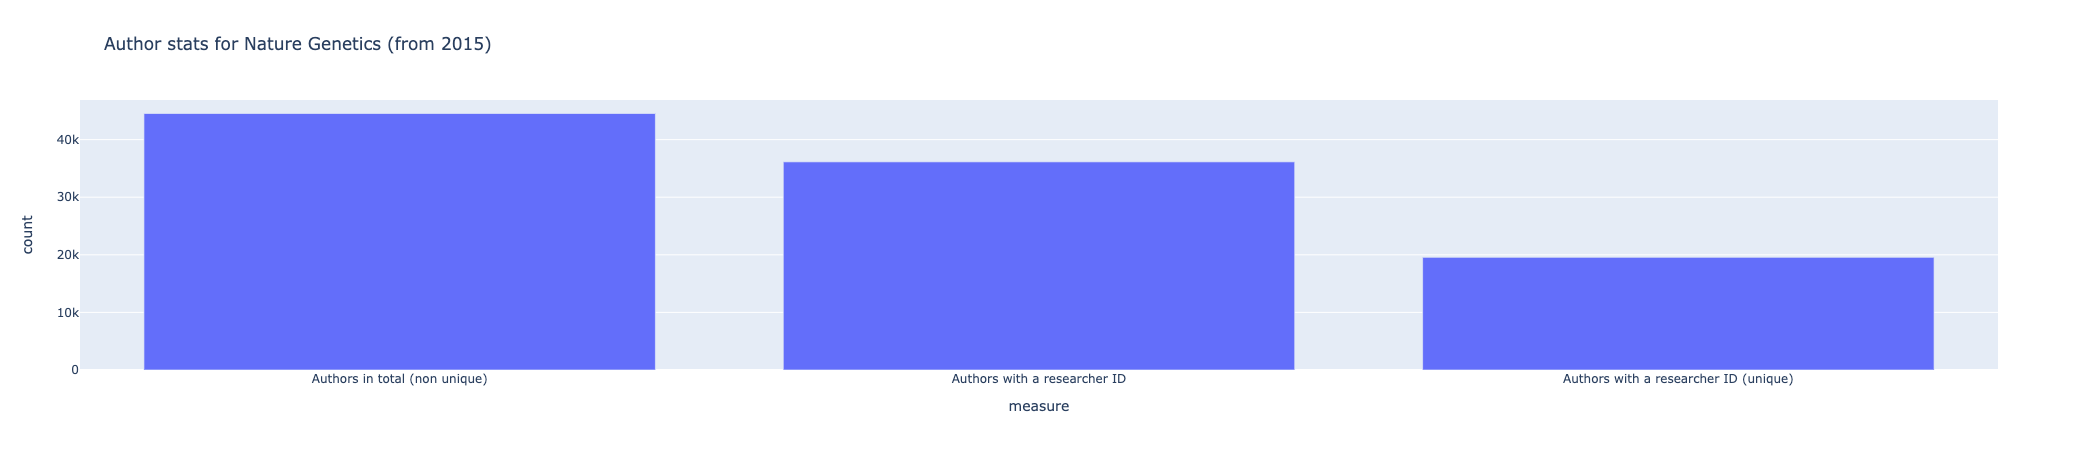

In [24]:
researchers = authors.query("researcher_id!=''")
#
df = pd.DataFrame({
    'measure' : ['Authors in total (non unique)', 'Authors with a researcher ID', 'Authors with a researcher ID (unique)'],
    'count' : [len(authors), len(researchers), researchers['researcher_id'].nunique()],
})
px.bar(df, x="measure", y="count", title=f"Author stats for {journal_title} (from {start_year})")

In [25]:
# save the researchers data to a file
save(researchers, "1_authors_with_researchers_id.csv")

## A quick look at authors *without* a Dimensions Researcher ID

We're not going to try to disambiguate them here, but still it's good to have a quick look at them... 

Looks like the most common surname is `Wang`, while the most common first name is an empty value

In [26]:
authors_without_id = authors.query("researcher_id==''")
authors_without_id[['first_name', 'last_name']].describe()

,first_name,last_name
count,8393,8393
unique,3747,3561
top,,
freq,565,464


Top ten 'ambiguous' surnames seem to be all Asian.. it's a rather known problem! 

In [27]:
authors_without_id['last_name'].value_counts()[:10]

         464
Wang     177
Li       145
Zhang    143
Liu      119
Chen     103
Yang      65
Zhao      61
Lee       55
Kim       47
Name: last_name, dtype: int64

### Any common patterns? 

If we try to group the data by name+surname we can see some interesting patterns 

* some entries are things which are not persons (presumably the results of bad source data in Dimensions, eg from the publisher) 
* there are some apparently meaningful name+surname combinations with a lot of hits
* not many Asian names in the top ones 



In [28]:
authors_without_id = authors_without_id.groupby(["first_name", "last_name"]).size().reset_index().rename(columns={0: "frequency"})
authors_without_id.sort_values("frequency", ascending=False, inplace=True)
authors_without_id.head(20)

,first_name,last_name,frequency
0,,,464
2074,Jaakko,Tuomilehto,13
2147,James G.,Wilson,12
5263,Wei,Zhao,12
2161,James P.,Cook,11
2385,Jie,Huang,11
3967,Olle,Melander,11
672,Brooke,LaFlamme,10
4228,Qiong,Yang,10
266,Andre,Franke,9


### Creating an export for manual curation

For the next tasks, we will focus on the disambiguated authors as the Researcher ID links will let us carry out useful analyses.

Still, we can **save the authors with missing IDs** results and try to do some manual disambiguation later. To this end, adding a simple google-search URL can help in making sense of these data quickly.

In [29]:
from dimcli.shortcuts import google_url

authors_without_id['search_url'] = authors_without_id.apply(lambda x: google_url(x['first_name'] + " " +x['last_name'] ), axis=1)

authors_without_id.head(20)

,first_name,last_name,frequency,search_url
0,,,464,https://www.google.com/search?q=%20
2074,Jaakko,Tuomilehto,13,https://www.google.com/search?q=Jaakko%20Tuomi...
2147,James G.,Wilson,12,https://www.google.com/search?q=James%20G.%20W...
5263,Wei,Zhao,12,https://www.google.com/search?q=Wei%20Zhao
2161,James P.,Cook,11,https://www.google.com/search?q=James%20P.%20Cook
2385,Jie,Huang,11,https://www.google.com/search?q=Jie%20Huang
3967,Olle,Melander,11,https://www.google.com/search?q=Olle%20Melander
672,Brooke,LaFlamme,10,https://www.google.com/search?q=Brooke%20LaFlamme
4228,Qiong,Yang,10,https://www.google.com/search?q=Qiong%20Yang
266,Andre,Franke,9,https://www.google.com/search?q=Andre%20Franke


In [30]:
# save the data
save(authors_without_id, "1_authors_without_researchers_id.csv")

That's it! 

Now let's go and open this in [Google Sheets](https://docs.google.com/spreadsheets/)...

In [31]:
# for colab users: download everything
if COLAB_ENV:
    from google.colab import auth
    auth.authenticate_user()

    import gspread
    from gspread_dataframe import get_as_dataframe, set_with_dataframe
    from oauth2client.client import GoogleCredentials

    gc = gspread.authorize(GoogleCredentials.get_application_default())

    title = 'Authors_without_IDs'
    sh = gc.create(title)
    worksheet = gc.open(title).sheet1
    set_with_dataframe(worksheet, authors_without_id)
    spreadsheet_url = "https://docs.google.com/spreadsheets/d/%s" % sh.id
    print(spreadsheet_url)